<a href="https://colab.research.google.com/github/Fourzeroo/My-Certificates/blob/main/Facial_Keypoints_Detection_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 6049 (delta 3), reused 3 (delta 0), pack-reused 6038
Receiving objects: 100% (6049/6049), 329.53 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

#Custom functions
import helper


from tqdm.notebook import tqdm
from torchvision import transforms
from sklearn.model_selection import train_test_split


# Configs

In [ ]:
TRAIN_IMG_DIR = '/content/P1_Facial_Keypoints/data/training'
TEST_IMG_DIR = '/content/P1_Facial_Keypoints/data/test'

TRAIN_CSV = '/content/P1_Facial_Keypoints/data/training_frames_keypoints.csv'
TEST_CSV = '/content/P1_Facial_Keypoints/data/test_frames_keypoints.csv'

DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.005
EPOCHS = 10
MODEL_NAME = 'resnet18'

# Understand Facial Keypoint Dataset

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


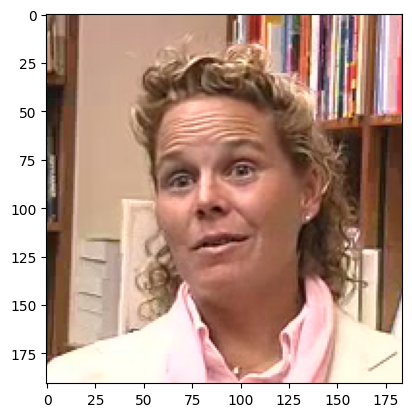

In [ ]:
# Взгялнем на 4 изображение Angelo_Reyes_22
idx = 4

img_name = train_df['Unnamed: 0'].iloc[idx]
img_path = TRAIN_IMG_DIR + '/' + img_name

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# это сделано для того что бы была возможность отобразить координаты точек на фотографии
key = train_df \
    .iloc[idx][1:] \
    .to_numpy(dtype='float32') \
    .reshape(-1, 2) # (136, ) -> (68, 2)

plt.imshow(img);

In [ ]:
# Отобразим получившиеся координаты на лицах
img = transforms.ToTensor()(img)
key = torch.from_numpy(key)

helper.imshow_with_key(img=img, key=key)

AttributeError: ignored

In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=1)

# Create Custom Facial Keypoint Dataset

albumentation : https://albumentations.ai/docs/  <br>

albumentation for keypoints : https://albumentations.ai/docs/examples/example_keypoints/

In [ ]:
import albumentations as A

In [ ]:
class FacicalKeyDataset(torch.utils.data.Dataset):

    def __init__(self, df, img_data_dir, augmentations=None):
        super(FacicalKeyDataset).__init__()
        self.df = df
        self.img_data_dir = img_data_dir
        self.augmentations = augmentations

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx: int):
        img_name = self.df['Unnamed: 0'].iloc[idx]
        img_path = self.img_data_dir + '/' + img_name

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # (136, ) -> (68, 2)
        key = self.df \
            .iloc[idx][1:] \
            .to_numpy(dtype='float32') \
            .reshape(-1, 2)

        if self.augmentations != None:
            augmentations_data = self.augmentations(image=img, keypoints=key)
            t_img = torch.from_numpy(augmentations_data['image']).float()
            t_key = torch.tensor(augmentations_data['keypoints']).float()

            # (H, W, C) -> (C, H, W),
            return t_img.permute(2, 0, 1), t_key.view(-1)



In [ ]:
import random


random.seed(7)
train_augs = A.Compose(
    [
        A.Resize(height=IMG_SIZE, width=IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.Normalize(),
        A.RandomBrightnessContrast(p=0.5)
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

valid_test_augs = A.Compose(
    [
        A.Resize(height=IMG_SIZE, width=IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.Normalize(),
        A.RandomBrightnessContrast(p=0.5)
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)


In [ ]:
trainset = FacicalKeyDataset(train_df, TRAIN_IMG_DIR, train_augs)
validset = FacicalKeyDataset(valid_df, TRAIN_IMG_DIR, valid_test_augs)
testset = FacicalKeyDataset(test_df, TEST_IMG_DIR, valid_test_augs)

In [ ]:
print("Total no. of examples present in trainset : {}".format(len(trainset)))
print("Total no. of examples present in validset : {}".format(len(validset)))
print("Total no. of examples present in validset : {}".format(len(testset)))

Total no. of examples present in trainset : 2769
Total no. of examples present in validset : 693
Total no. of examples present in validset : 770


In [ ]:
img, key = trainset[435]
h.imshow_with_key(img, key);

AttributeError: ignored

# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validloader = DataLoader(dataset=validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 174
Total no. batches in validloader : 44


In [ ]:
for data in trainloader:
    image, key = data
    break

In [ ]:
print("Shape of one batch image : {}".format(image.shape))
print("Shape of one batch key : {}".format(key.shape))

Shape of one batch image : torch.Size([16, 3, 140, 140])
Shape of one batch key : torch.Size([16, 136])


# Create Model

ckeck out timm : https://rwightman.github.io/pytorch-image-models/ (documentation), https://github.com/rwightman/pytorch-image-models (github repo)

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00


In [ ]:
import timm

In [ ]:
class FacialKeyModel(torch.nn.Module):

    def __init__(self, model_name=MODEL_NAME):
        super(FacialKeyModel, self).__init__()
        print(f'Loading... {model_name}')
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=136)

    def forward(self, images, keys=None):

        logits = self.backbone(images)

        if keys != None:
            return logits, torch.nn.MSELoss()(logits, keys)

        return logits

In [ ]:
model = FacialKeyModel()

def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model.to(DEVICE)

Loading... resnet18


FacialKeyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [ ]:
print(f"Количество параметров модели: {count_param(model)}")

Количество параметров модели: 11246280


# Trainer and Evaluator

In [ ]:
from torch.amp.autocast_mode import autocast


def train_fn(model, trainloader, optimizer):

    with autocast(device_type=DEVICE):
        train_loss = 0.0
        model.train()

    for data in trainloader:
        images, keys = data
        images, keys = images.to(DEVICE), keys.to(DEVICE)

        output, loss = model(images, keys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(trainloader)


In [ ]:
def eval_fn(model, validloader):

    model.eval()  # переводим модель в режим оценки
    valid_loss = 0.0
    with torch.no_grad():
        for data in tqdm(validloader):
            images, keys = data
            images, keys = images.to(DEVICE), keys.to(DEVICE)

            output, loss = model(images, keys)

            valid_loss += loss.item()

    return valid_loss / len(validloader)

# Training model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_valid_loss = np.Inf


for epoch in range(EPOCHS):
    avg_train_loss = train_fn(model=model, trainloader=trainloader, optimizer=optimizer)
    avg_valid_loss = eval_fn(model=model, validloader=validloader)

    if avg_valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'FacialKeyModel')
        best_valid_loss = avg_valid_loss

    print(f'Epoch : {epoch} Train_loss: {avg_train_loss}')
    print(f'Epoch : {epoch} Valid_loss: {avg_valid_loss}')

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 0 Train_loss: 119.85696490057583
Epoch : 0 Valid_loss: 119.81998738375577


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 1 Train_loss: 116.5583952542009
Epoch : 1 Valid_loss: 115.44750716469504


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 2 Train_loss: 115.36333458999107
Epoch : 2 Valid_loss: 118.61056275801225


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 3 Train_loss: 113.33304780105064
Epoch : 3 Valid_loss: 112.58087435635653


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 4 Train_loss: 109.86691608648191
Epoch : 4 Valid_loss: 120.56269004128195


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 5 Train_loss: 107.8921714431938
Epoch : 5 Valid_loss: 109.56266403198242


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 6 Train_loss: 97.3352661790519
Epoch : 6 Valid_loss: 113.50825413790616


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 7 Train_loss: 92.19189685514604
Epoch : 7 Valid_loss: 118.27256220037287


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 8 Train_loss: 79.86442153755276
Epoch : 8 Valid_loss: 108.31570607965642


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch : 9 Train_loss: 71.96868415262507
Epoch : 9 Valid_loss: 104.28571345589377


### Model Trained on Google Colab GPU : https://colab.research.google.com/drive/1tQp1IGvM7yQDZ1Weygi40mUfMPHrUd_K?usp=sharing

# Visualizing Predictions

In [ ]:
def compare_keypoints(image, key, out_key):
	image = image.squeeze().permute(1,2,0)
	image = image.cpu().detach().numpy()
	image = image * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])

	f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

	ax1.set_title('original-keypoints')
	ax1.imshow(image)
	key = key.view(-1,2).cpu().detach().numpy()
	ax1.scatter(key[:,0],key[:,1], s = 10, c = 'b')

	ax2.set_title('model-keypoints')
	ax2.imshow(image)
	out_key = out_key.view(-1,2).cpu().detach().numpy()
	ax2.scatter(out_key[:,0],out_key[:,1], s = 10, c = 'g')

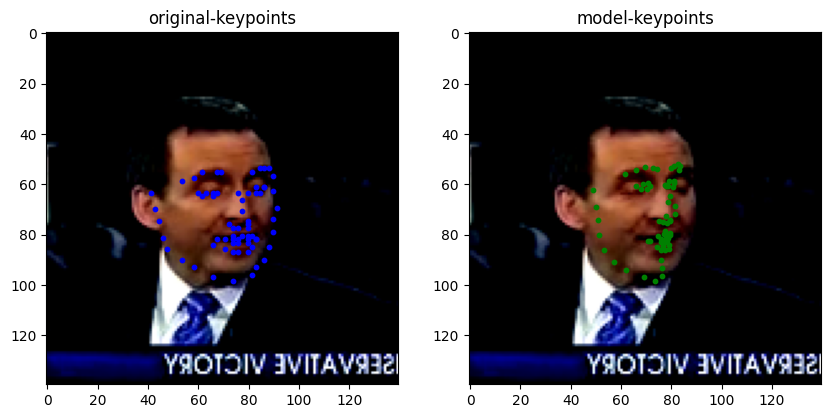

In [ ]:
index = 9
image, key = testset[index]

model.load_state_dict(torch.load('FacialKeyModel', map_location=DEVICE))

model.eval()
with torch.no_grad():
    image = image.to(DEVICE)
    out_key = model(image.unsqueeze(0))
    compare_keypoints(image, key, out_key)


# Optional Task